In [1]:
import numpy as np
np.set_printoptions(precision=4)
from pathlib import Path
import mujoco
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError
import cvxopt as cvx

In [2]:
# contact_data_dir = "22032024-110615" # Transposed contact frame
contact_data_dir =  "26032024-114112" # Untranslated force vectors

## Define Convex Hull Volume Function

In [3]:
def cvx_vol(all_coordinates):
    try:
        hull = ConvexHull(all_coordinates)
        return hull.volume, True    
    except (QhullError, ValueError):
        return 0.0, False

## Define Wrench Space Rank

In [4]:
def wrench_rank(wrenches):
    try:
        return np.linalg.matrix_rank(wrenches)
    except ValueError:
        return 0

## Define Wrench Space Volume

In [5]:
# using product of singular vectors(generalized determinant of non square matrices)
def wrench_vol(wrenches):
    if wrenches.size == 0:
        return 0
    try:
        _, S, _ = np.linalg.svd(wrenches)
        sig = S
        return np.sqrt(np.prod(sig))
    except ValueError:
        return 0

## Define epsilon metric

In [6]:
# This code is adapted from DexNet at https://github.com/BerkeleyAutomation/dex-net/blob/master/src/dexnet/grasping/quality.py#L670

def min_norm_vector_in_facet(facet, wrench_regularizer=1e-10):
        dim = facet.shape[1] # num vertices in facet

        # create alpha weights for vertices of facet
        G = facet.T.dot(facet)
        grasp_matrix = G + wrench_regularizer * np.eye(G.shape[0])

        # Solve QP to minimize .5 x'Px + q'x subject to Gx <= h, Ax = b
        P = cvx.matrix(2 * grasp_matrix)   # quadratic cost for Euclidean dist
        q = cvx.matrix(np.zeros((dim, 1)))
        G = cvx.matrix(-np.eye(dim))       # greater than zero constraint
        h = cvx.matrix(np.zeros((dim, 1)))
        A = cvx.matrix(np.ones((1, dim)))  # sum constraint to enforce convex
        b = cvx.matrix(np.ones(1))         # combinations of vertices

        sol = cvx.solvers.qp(P, q, G, h, A, b)
        v = np.array(sol['x'])
        min_norm = np.sqrt(sol['primal objective'])

        return abs(min_norm), v

def epsilon(wrenches, wrench_norm_thresh=1e-2, wrench_regularizer=1e-10):
    G = wrenches

    try:
        hull = ConvexHull(wrenches.T)
    
        if len(hull.simplices) == 0:
            print('Convex hull could not be computed')
            return 0.0, False
    
        # determine whether or not zero is in the convex hull
        min_norm_in_hull, v = min_norm_vector_in_facet(G, wrench_regularizer=wrench_regularizer)
    
        # print(f"min_norm_in_hull: {min_norm_in_hull} -- v:{v}")
        
        # if norm is greater than 0 then forces are outside of hull
        if min_norm_in_hull > wrench_norm_thresh:
            print('Zero not in convex hull')
            return 0.0, False
    
        # if there are fewer nonzeros than D-1 (dim of space minus one)
        # then zero is on the boundary and therefore we do not have
        # force closure
        if np.sum(v > 1e-4) <= G.shape[0]-1:
            print('Zero not in interior of convex hull')
            return 0.0, False
    
        # find minimum norm vector across all facets of convex hull
        min_dist = sys.float_info.max
        closest_facet = None
        for v in hull.simplices:
            if np.max(np.array(v)) < G.shape[1]: # because of some occasional odd behavior from pyhull
                facet = G[:, v]
                dist, _ = min_norm_vector_in_facet(facet, wrench_regularizer=wrench_regularizer)
                if dist < min_dist:
                    min_dist = dist
                    closest_facet = v
        return min_dist, True
    except (QhullError, ValueError):
        return 0.0, False

## Collect data

In [7]:
axes = ["x", "y"]
angles = np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18)
cloth_names = [25]
column_names = ["cloth", "axis", "angle", "num_points", "points_cvx_vol", 
                "points_cvx_vol_exists", "wrench_rank", "wench_vol", 
                "epsilon", "epsilon_exists"]
data = []
for cloth_name in cloth_names:
    angles = np.rad2deg(np.arange(-np.pi/6, np.pi/6+np.pi/18, step=np.pi/18))
    combinations = itertools.product(['x', 'y'], angles)
    combinations = [(ax, ang) for ax, ang in combinations if ax == 'x' or ang != 0]
    for (axis, angle) in combinations:
        angle = f"{angle:.0f}"
        file_path = Path(contact_data_dir) / f"{cloth_name}_{axis}_{angle}.npy"
        scene_xml = Path("xmls") / f"{cloth_name}_scene.xml"

        model = mujoco.MjModel.from_xml_path(str(scene_xml.resolve()))
        left_finger_id = model.geom('gripper0_finger1_collision').id
        right_finger_id = model.geom('gripper0_finger2_collision').id

        contacts = np.load(file_path,allow_pickle='TRUE').item()
        left_finger_mask = ((contacts['geom'][:, 0] == left_finger_id) | (
                    contacts['geom'][:, 1] == left_finger_id))
        left_contact_points = np.nonzero(left_finger_mask)
        right_finger_mask = ((contacts['geom'][:, 0] == right_finger_id) | (
                    contacts['geom'][:, 1] == right_finger_id))
        right_contact_points = np.nonzero(right_finger_mask)
        left_contact_coordinates = contacts['pos'][left_contact_points]
        right_contact_coordinates = contacts['pos'][right_contact_points]
        all_coordinates = np.concatenate((left_contact_coordinates, right_contact_coordinates))

        cvx_volume, cvx_volume_success = cvx_vol(all_coordinates)
        e, epsilon_exists = epsilon(contacts['forces'])
        wrench_vol, _ = cvx_vol(contacts['forces'])
        data.append([cloth_name, axis, angle, len(all_coordinates),
                            cvx_volume, cvx_volume_success, wrench_rank(contacts['forces']),
                            wrench_vol, e, epsilon_exists])

name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section
name == plugin section


In [8]:
df = pd.DataFrame(data, columns=column_names)

In [9]:
def draw_images(cloth, axis, angle):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, camera in zip(axs, ['robot0_robotview', 'sideview', 'robot0_eye_in_hand']):
        contact_image = Path(contact_data_dir) / f"{cloth}_{axis}_{angle}_{camera}.png"
        ax.imshow(plt.imread(contact_image))
        ax.set_title(camera)
    plt.show()

## Qualitative Analysis of cloth with 25 bodies

In [10]:
cloth_25 = df[df['cloth'] == 25]

## Effect of num of points on the grasp quality

In [11]:
cloth_25.sort_values(by=['num_points'], ascending=False)

,cloth,axis,angle,num_points,points_cvx_vol,points_cvx_vol_exists,wrench_rank,wench_vol,epsilon,epsilon_exists
3,25,x,0,7,1.339983e-06,True,4,0.000000,0.0,False
10,25,y,0,7,1.305034e-06,True,4,0.000000,0.0,False
11,25,y,10,7,1.591146e-06,True,4,0.000000,0.0,False
12,25,y,20,7,2.487825e-06,True,4,0.000000,0.0,False
13,25,y,30,7,1.372320e-06,True,4,0.000000,0.0,False
2,25,x,-10,5,1.287028e-07,True,4,0.000000,0.0,False
6,25,x,30,5,2.734748e-08,True,4,0.000000,0.0,False
9,25,y,-10,5,5.463560e-08,True,4,0.000000,0.0,False
1,25,x,-20,4,7.770610e-09,True,4,0.000441,0.0,False
4,25,x,10,4,1.068888e-09,True,4,0.000614,0.0,False


## Grasp with max number of points

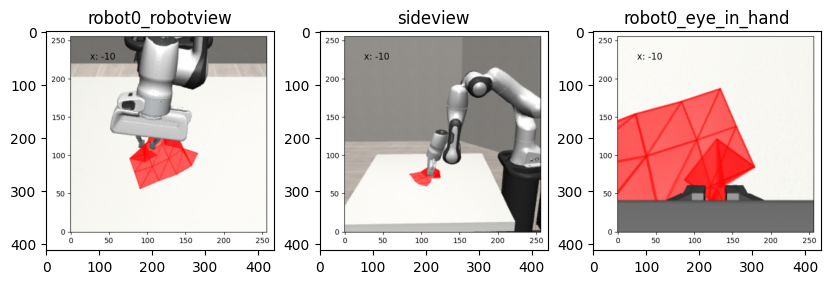

In [12]:
cloth = "25"
axis = "x"
angle = "-10"

draw_images(cloth, axis, angle)

## Grasp with min number of contact points

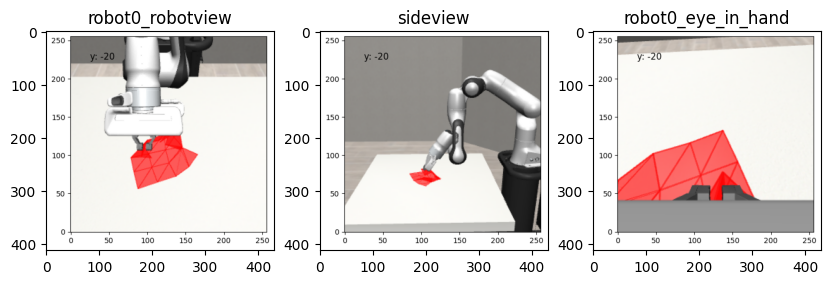

In [13]:
cloth = "25"
axis = "y"
angle = "-20"

draw_images(cloth, axis, angle)

## Effect of convex hull volume of the coordinate space

In [14]:
cloth_25.sort_values(by=['points_cvx_vol'], ascending=False)

,cloth,axis,angle,num_points,points_cvx_vol,points_cvx_vol_exists,wrench_rank,wench_vol,epsilon,epsilon_exists
12,25,y,20,7,2.487825e-06,True,4,0.000000,0.0,False
11,25,y,10,7,1.591146e-06,True,4,0.000000,0.0,False
13,25,y,30,7,1.372320e-06,True,4,0.000000,0.0,False
3,25,x,0,7,1.339983e-06,True,4,0.000000,0.0,False
10,25,y,0,7,1.305034e-06,True,4,0.000000,0.0,False
2,25,x,-10,5,1.287028e-07,True,4,0.000000,0.0,False
9,25,y,-10,5,5.463560e-08,True,4,0.000000,0.0,False
6,25,x,30,5,2.734748e-08,True,4,0.000000,0.0,False
5,25,x,20,4,1.551863e-08,True,4,0.000813,0.0,False
1,25,x,-20,4,7.770610e-09,True,4,0.000441,0.0,False


## Contact wit max volume

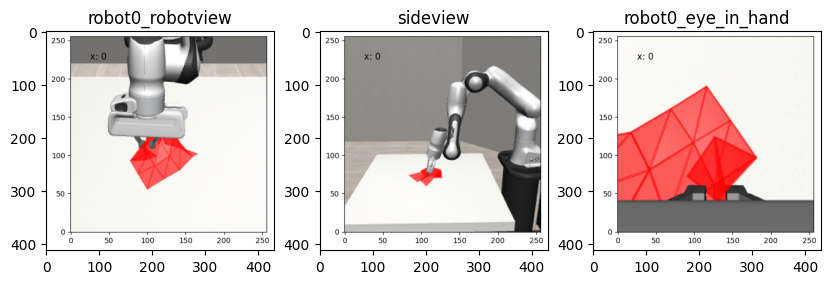

In [15]:
cloth = "25"
axis = "x"
angle = "0"

draw_images(cloth, axis, angle)

## Contact with min volume

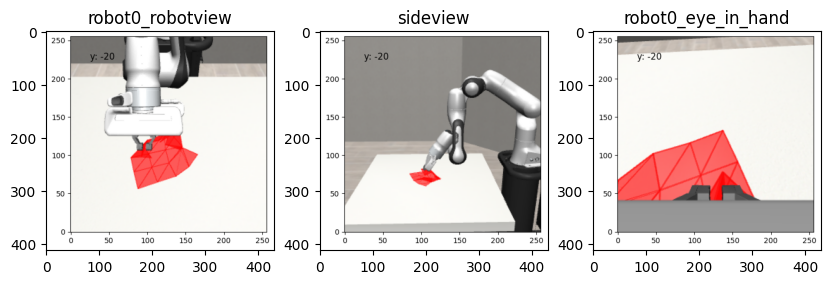

In [16]:
cloth = "25"
axis = "y"
angle = "-20"

draw_images(cloth, axis, angle)

## Effect of wrench space volume

In [17]:
cloth_25.sort_values(by=['wench_vol'], ascending=False)

,cloth,axis,angle,num_points,points_cvx_vol,points_cvx_vol_exists,wrench_rank,wench_vol,epsilon,epsilon_exists
0,25,x,-30,3,0.000000e+00,False,3,0.946821,0.0,False
7,25,y,-30,3,0.000000e+00,False,3,0.000842,0.0,False
5,25,x,20,4,1.551863e-08,True,4,0.000813,0.0,False
8,25,y,-20,3,0.000000e+00,False,3,0.000647,0.0,False
4,25,x,10,4,1.068888e-09,True,4,0.000614,0.0,False
1,25,x,-20,4,7.770610e-09,True,4,0.000441,0.0,False
2,25,x,-10,5,1.287028e-07,True,4,0.000000,0.0,False
3,25,x,0,7,1.339983e-06,True,4,0.000000,0.0,False
6,25,x,30,5,2.734748e-08,True,4,0.000000,0.0,False
9,25,y,-10,5,5.463560e-08,True,4,0.000000,0.0,False


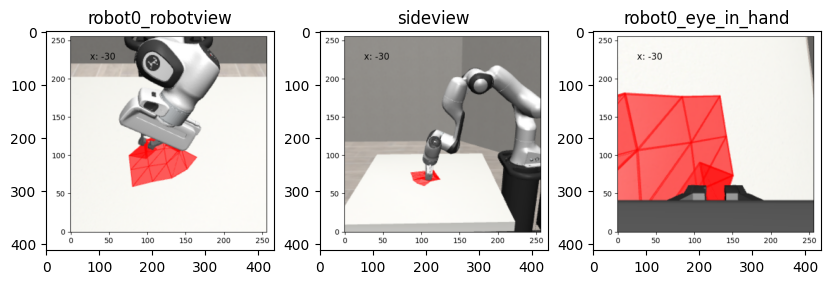

In [18]:
cloth = "25"
axis = "x"
angle = "-30"

draw_images(cloth, axis, angle)

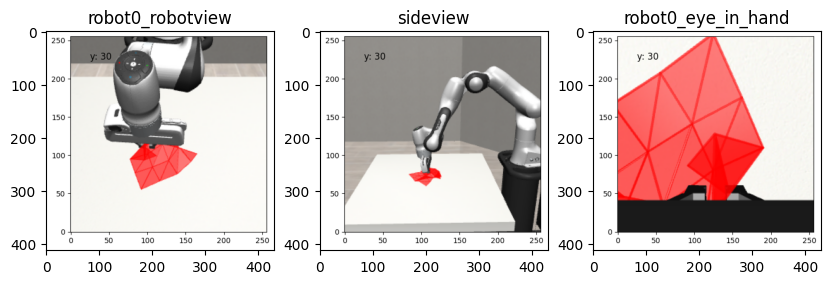

In [19]:
cloth = "25"
axis = "y"
angle = "30"

draw_images(cloth, axis, angle)

## Qualitative Analysis of cloth with 50 bodies

In [20]:
cloth_50 = df[df['cloth'] == 50]

## Effect of num of points on the grasp quality

In [21]:
cloth_50.sort_values(by=['num_points'], ascending=False)

,cloth,axis,angle,num_points,points_cvx_vol,points_cvx_vol_exists,wrench_rank,wench_vol,epsilon,epsilon_exists


FileNotFoundError: [Errno 2] No such file or directory: '26032024-114112/50_x_0_robot0_robotview.png'

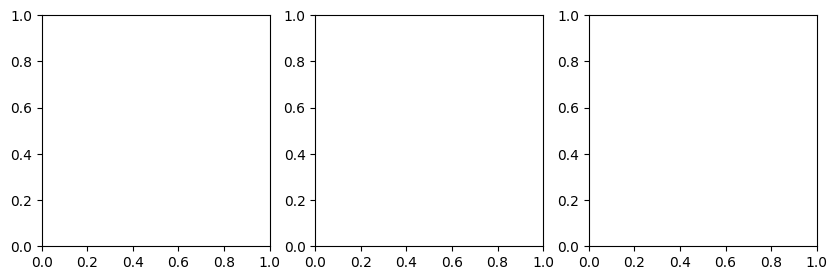

In [22]:
cloth = "50"
axis = "x"
angle = "0"

draw_images(cloth, axis, angle)

In [ ]:
cloth = "50"
axis = "y"
angle = "-30"

draw_images(cloth, axis, angle)

In [ ]:
cloth = "50"
axis = "x"
angle = "10"

draw_images(cloth, axis, angle)

## Effect of convex hull volume on the grasp quality 

In [ ]:
cloth_50.sort_values(by=['points_cvx_vol'], ascending=False)

In [ ]:
cloth = "50"
axis = "x"
angle = "20"

draw_images(cloth, axis, angle)

In [ ]:
cloth = "50"
axis = "y"
angle = "-20"

draw_images(cloth, axis, angle)

In [ ]:
cloth_50.sort_values(by=['wench_vol'], ascending=False)

In [ ]:
cloth = "50"
axis = "y"
angle = "0"

draw_images(cloth, axis, angle)

In [ ]:
cloth = "50"
axis = "x"
angle = "10"

draw_images(cloth, axis, angle)